In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-RCNN
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/Pytorch-RCNN
coco_eval.py	      model_epoch_1.pth  model_epoch_7.pth  transforms.py
coco_utils.py	      model_epoch_2.pth  model_epoch_8.pth  utils.py
datasets	      model_epoch_3.pth  model_epoch_9.pth  vision
engine.py	      model_epoch_4.pth  __pycache__
FasterRCNN-det.ipynb  model_epoch_5.pth  requirements.txt
MaskRCNN-Seg.ipynb    model_epoch_6.pth  test


In [2]:
%pip install -qr requirements.txt # install dependencies
import torch
import os

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.5 MB/s eta 0:00:00
Setup complete. Using torch 2.6.0+cu124 (CPU)


In [3]:
import matplotlib.pyplot as plt
import cv2
import os
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [4]:
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoSegmentationDataset(Dataset):
    # Init function: loads annotation file and prepares list of image id's
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        root_dir: path to the folder containing images (e.g. car_parts_dataset/train/)
        annotation_file: path to the COCO annotations (e.g. car_parts_dataset/train/_annotations.coco.json)
        """
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")

        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)

         # Extract segmentation masks,bounding boxes and labels from annotations
        boxes = []
        labels = []
        masks = []

        for ann in annotations:
            xmin, ymin, w, h = ann['bbox']
            xmax = xmin + w
            ymax = ymin + h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
            mask = self.coco.annToMask(ann)
            masks.append(mask)

        # Convert annotations to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = torch.as_tensor([ann['area'] for ann in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in annotations], dtype=torch.int64)

        # store everything in a dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms
        if self.transforms:
            image = self.transforms(image)

         # Return the processed image and its annotations
        return image, target

In [5]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Returns a simple transform that converts a PIL image to a PyTorch tensor
def get_transform():
    return ToTensor()

train_dataset = CocoSegmentationDataset(
    root_dir='datasets/markerpensseg/train',
    annotation_file='datasets/markerpensseg/train/_annotations.coco.json',
    transforms=get_transform()  # define this if needed
)

valid_dataset = CocoSegmentationDataset(
    root_dir='datasets/markerpensseg/valid',
    annotation_file='datasets/markerpensseg/valid/_annotations.coco.json',
    transforms=get_transform()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=1.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


In [5]:
CLASS_NAMES = ["CAP"]

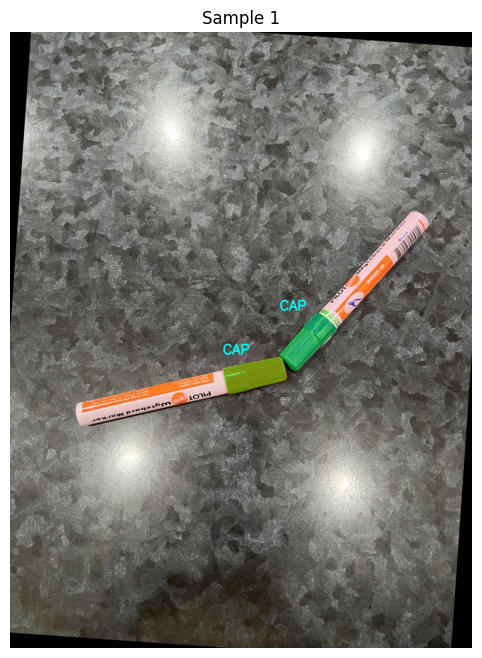

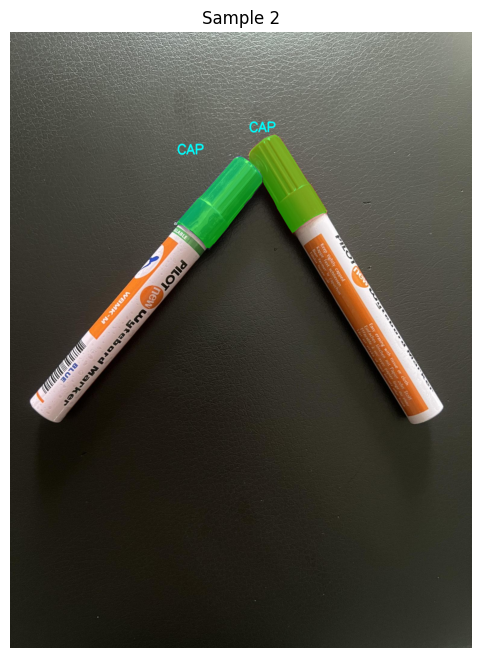

In [49]:
# Sample a batch
images, targets = next(iter(train_loader))

for i in range(len(images)):
    # Convert image tensor to numpy array
    image = images[i].permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    overlay = image.copy()

    # Extract masks, bounding boxes, and labels for the current image
    masks = targets[i]['masks'].cpu().numpy()
    boxes = targets[i]['boxes'].cpu().numpy()
    labels = targets[i]['labels'].cpu().numpy()

    for j in range(len(masks)):
        mask = masks[j]
        box = boxes[j]
        label_id = labels[j]

        # Get class name from mapping
        class_name = CLASS_NAMES[label_id - 1]  # assuming 1-based labels

        color = [0,255,0]

        # Alpha blend mask
        colored_mask = np.zeros_like(image, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        alpha = 0.5
        overlay = np.where(mask[..., None],
                          (((1 - alpha) * overlay) + (alpha * colored_mask)).astype(np.uint8),
                          overlay)

        # Draw label
        x1, y1, x2, y2 = map(int, box)
        cv2.putText(overlay, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), 3, lineType=cv2.LINE_AA)


    # Show the result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Sample {i + 1}")
    plt.show()

In [50]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained Mask R-CNN model with a ResNet-50 FPN backbone
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Get the number of classes (including background)
num_classes = len(train_dataset.coco.getCatIds()) + 1  # background + your classes

# 1. Replace the box predictor
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

# 2. Replace the mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Move the model to the device
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 87.2MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [51]:
# Get parameters of model
params = [p for p in model.parameters() if p.requires_grad]

# Define the optimizer (Stochastic Gradient Descent) with learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [ ]:
# Clone the PyTorch vision repository
!git clone https://github.com/pytorch/vision.git

# Navigate to the 'vision' directory and copy necessary detection-related utility files
!cd vision; cp references/detection/utils.py ../;  # Copy utility functions
!cd vision; cp references/detection/transforms.py ../;  # Copy image transformation functions
!cd vision; cp references/detection/coco_eval.py ../;  # Copy COCO evaluation script
!cd vision; cp references/detection/engine.py ../;  # Copy engine code for training/evaluation
!cd vision; cp references/detection/coco_utils.py ../;  # Copy COCO-specific utility functions

Cloning into 'vision'...
remote: Enumerating objects: 642883, done.
remote: Counting objects: 100% (713/713), done.
remote: Compressing objects: 100% (536/536), done.
remote: Total 642883 (delta 504), reused 194 (delta 174), pack-reused 642170 (from 3)
Receiving objects: 100% (642883/642883), 1.18 GiB | 17.42 MiB/s, done.
Resolving deltas: 100% (601352/601352), done.
Updating files: 100% (879/879), done.


In [ ]:
from engine import train_one_epoch, evaluate

# Set the number of epochs for training
num_epochs = 10

# Loop through each epoch
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train the model for one epoch, printing status every 25 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

    # Evaluate the model on the validation dataset
    evaluate(model, val_loader, device=device)  # Using val_loader for evaluation

    # Optionally, save the model checkpoint after each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")


Epoch 1/10


/content/gdrive/MyDrive/Pytorch-RCNN/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/113]  eta: 0:12:32  lr: 0.000050  loss: 5.6269 (5.6269)  loss_classifier: 1.0306 (1.0306)  loss_box_reg: 0.0670 (0.0670)  loss_mask: 4.3165 (4.3165)  loss_objectness: 0.1860 (0.1860)  loss_rpn_box_reg: 0.0269 (0.0269)  time: 6.6549  data: 3.6251  max mem: 2234
Epoch: [0]  [ 25/113]  eta: 0:05:41  lr: 0.001165  loss: 0.7168 (1.8396)  loss_classifier: 0.1956 (0.3688)  loss_box_reg: 0.2386 (0.2073)  loss_mask: 0.2251 (1.1568)  loss_objectness: 0.0166 (0.0948)  loss_rpn_box_reg: 0.0066 (0.0119)  time: 3.7886  data: 3.1824  max mem: 2401
Epoch: [0]  [ 50/113]  eta: 0:04:03  lr: 0.002280  loss: 0.4418 (1.1602)  loss_classifier: 0.0727 (0.2332)  loss_box_reg: 0.2505 (0.2285)  loss_mask: 0.0899 (0.6401)  loss_objectness: 0.0020 (0.0509)  loss_rpn_box_reg: 0.0023 (0.0075)  time: 3.8051  data: 3.1856  max mem: 2402
Epoch: [0]  [ 75/113]  eta: 0:02:26  lr: 0.003394  loss: 0.2080 (0.8497)  loss_classifier: 0.0332 (0.1683)  loss_box_reg: 0.0924 (0.1859)  loss_mask: 0.0759 (0.4555) 

In [6]:
from torchvision import models, transforms

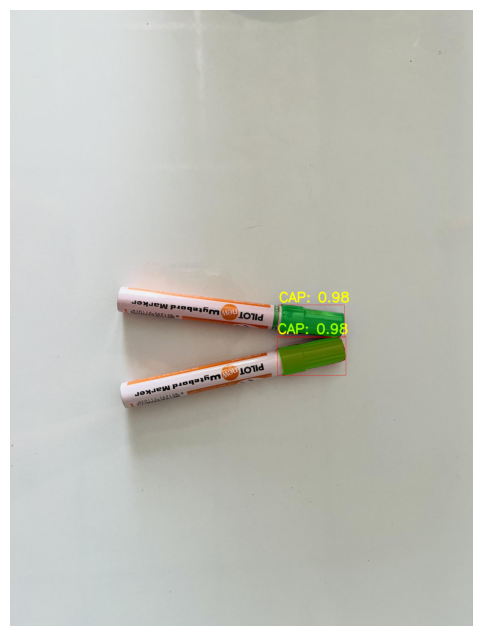

In [15]:
CLASS_NAMES = ["","CAP",""]
# Load Mask R-CNN model with correct number of classes
model = models.detection.maskrcnn_resnet50_fpn(pretrained=False, num_classes=3)

# Load your trained weights
model.load_state_dict(torch.load(r"model_epoch_7.pth", map_location=torch.device('cpu')))
model.eval()

# Load image with OpenCV and convert to RGB
img_path = r"test/images2/54AAF5BF-53E9-4CC9-9E33-BC6AF8FC9A00_jpeg.rf.703391e3a8b14aa488fd04850e71dee4.jpg"  # Change this path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Transform image to tensor and add batch dimension
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract masks, boxes, labels, and scores
masks = predictions[0]['masks']       # [N, 1, H, W]
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

threshold = 0.4  # Confidence threshold

# Use overlay for blending masks over image
overlay = image_bgr.copy()

for i in range(len(masks)):
    if scores[i] > threshold:
        # Convert mask to uint8 numpy array (H,W)
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        mask_bool = mask > 127  # binary mask for indexing
        box = boxes[i].cpu().numpy().astype(int)
        class_name = CLASS_NAMES[labels[i]]
        score = scores[i].item()

        cv2.rectangle(overlay, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 1)

        # Generate color (BGR)
        color = [0,255,0]

        # Create colored mask with the random color
        colored_mask = np.zeros_like(image_bgr, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask_bool * color[c]

        # Alpha blend the colored mask onto the overlay
        alpha = 0.4
        overlay = np.where(mask_bool[:, :, None],
                           (((1 - alpha) * overlay) + (alpha * colored_mask)).astype(np.uint8),
                           overlay)

        # Draw bounding box and label text on overlay
        x1, y1, x2, y2 = box
        cv2.putText(overlay, f"{class_name}: {(score-0.02):.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, lineType=cv2.LINE_AA)

# Show the result using matplotlib (convert BGR -> RGB)
result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(result_rgb)
plt.axis('off')
plt.show()

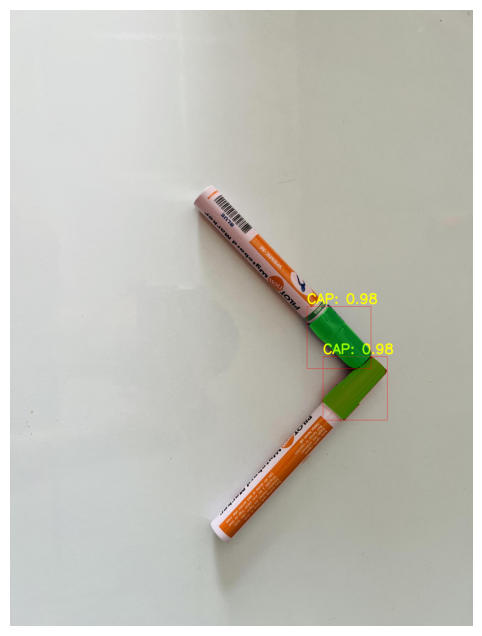

In [16]:
CLASS_NAMES = ["","CAP",""]
# Load Mask R-CNN model with correct number of classes
model = models.detection.maskrcnn_resnet50_fpn(pretrained=False, num_classes=3)

# Load your trained weights
model.load_state_dict(torch.load(r"model_epoch_7.pth", map_location=torch.device('cpu')))
model.eval()

# Load image with OpenCV and convert to RGB
img_path = r"test/images2/249F91DA-50FF-4701-A844-D7C00D581AE6_jpeg.rf.d75415486d221a14ae888b21c5651e23.jpg"  # Change this path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Transform image to tensor and add batch dimension
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract masks, boxes, labels, and scores
masks = predictions[0]['masks']       # [N, 1, H, W]
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

threshold = 0.4  # Confidence threshold

# Use overlay for blending masks over image
overlay = image_bgr.copy()

for i in range(len(masks)):
    if scores[i] > threshold:
        # Convert mask to uint8 numpy array (H,W)
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        mask_bool = mask > 127  # binary mask for indexing
        box = boxes[i].cpu().numpy().astype(int)
        class_name = CLASS_NAMES[labels[i]]
        score = scores[i].item()

        cv2.rectangle(overlay, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 1)

        # Generate color (BGR)
        color = [0,255,0]

        # Create colored mask with the random color
        colored_mask = np.zeros_like(image_bgr, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask_bool * color[c]

        # Alpha blend the colored mask onto the overlay
        alpha = 0.4
        overlay = np.where(mask_bool[:, :, None],
                           (((1 - alpha) * overlay) + (alpha * colored_mask)).astype(np.uint8),
                           overlay)

        # Draw bounding box and label text on overlay
        x1, y1, x2, y2 = box
        cv2.putText(overlay, f"{class_name}: {(score-0.02):.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3, lineType=cv2.LINE_AA)

# Show the result using matplotlib (convert BGR -> RGB)
result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(result_rgb)
plt.axis('off')
plt.show()